## DDM

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
from typing import Optional, Callable, Dict
from scipy.optimize import minimize

from src.decision_models import *

## Model parameters

lb → 0, 
ub → a (0.5, 2),
z → (0,1)
drift-gain → (0, some number)
drift-offset → (-some number*100, + some number*100)
leak → (0,xx)
dt → 1ms
Ter → (0, maxRT)
time-varying weights → exp(- lambda* t) 
lambda→(0,1)

In [2]:
def get_psychometric_data(data, positive_direction="right"):
    """Extracts psychometric data and optionally fits a model."""
    unique_coh = np.unique(data["signed_coherence"])
    x_data = np.where(positive_direction == "left", -unique_coh, unique_coh)
    y_data = []
    trial_counts = []
    for coh in unique_coh:
        mask = (data["signed_coherence"] == coh) & (~np.isnan(data["choice"]))
        total_trials = np.sum(mask)

        if total_trials == 0:
            continue  # Skip coherence levels with no trials

        prop_positive = np.mean(data["choice"][mask] == (positive_direction == "right"))
        y_data.append(prop_positive)
        trial_counts.append(total_trials)

    # Convert to numpy arrays and sort
    x_data, y_data, trial_counts = map(np.array, zip(*sorted(zip(x_data, y_data, trial_counts, strict=False)), strict=False))


    return x_data, y_data


def get_chronometric_data(data, positive_direction="right"):
    """Computes reaction time statistics for different coherence levels."""
    unique_coh = np.unique(data["signed_coherence"])
    coherences, rt_median, rt_mean, rt_sd, rt_sem = [], [], [], [], []

    for coh in unique_coh:
        trials = data[data["signed_coherence"] == coh]
        if trials.empty:
            continue

        coherences.append(coh if positive_direction == "right" else -coh)
        rt_median.append(np.median(trials["response_time"]))
        rt_mean.append(np.mean(trials["response_time"]))
        rt_sd.append(np.std(trials["response_time"]))
        rt_sem.append(stats.sem(trials["response_time"],nan_policy='omit'))

    return map(np.array, zip(*sorted(zip(coherences, rt_median, rt_mean, rt_sd, rt_sem, strict=False)), strict=False))


In [3]:
# stimulus_length = np.random.randint(300,1000,size=1000)
stimulus = np.full((1000, 1000), np.nan)
coherence_levels = [-0.5, -0.2, -0.06, 0.0, 0.06, 0.2, 0.5]
for i in range(1000):
    stimulus[i, :] = np.random.choice(coherence_levels)


In [4]:
class DriftDiffusionSimulator:
    def __init__(self, leak=True, time_dependence=True):
        """Initialize parameters for the diffusion model."""
        self.ndt = 0.1      # non-decision time
        self.a = 2        # boundary separation
        self.z = 0.5          # starting point (as a proportion of a)
        self.drift_gain = 7 # gain on the input to get drift rate
        self.drift_offset = 0.0
        self.variance = 1   # variance of the noise in the accumulation process
        self.dt = 0.001        # time step for simulation
        self.leak_rate = 0.01 if leak else 0    # leakage parameter
        self.time_constant = 1e-2 if time_dependence else 0 # urgency signal time constant

    def simulate_trials(self, stimulus):
        """Simulate trials of the diffusion model given a stimulus."""
        n_trials = stimulus.shape[0]
        n_timepoints = stimulus.shape[1]

        # Preallocate arrays for decision variables and responses
        evidence = np.full((n_trials, n_timepoints), np.nan)
        dv = np.full((n_trials, n_timepoints),np.nan)
        rt = np.full(n_trials, np.nan)
        choice = np.full(n_trials, np.nan)

        # Calculate drift rates based on stimulus and gain
        drift_rates = self.drift_gain * stimulus + self.drift_offset
        starting_point = self.z * self.a
        urgency = np.exp(np.arange(n_timepoints) * self.time_constant)
        noise = np.random.normal(0, np.sqrt(self.variance * self.dt), size=(n_trials, n_timepoints))
        for trial in range(n_trials):
            evidence[trial, 0] = starting_point
            dv[trial, 0] = starting_point
            for t in range(1, n_timepoints):
                if np.isnan(stimulus[trial, t]):
                    break # no response

                momentary_evidence = drift_rates[trial, t-1] * self.dt + noise[trial, t-1]
                leakage = self.leak_rate * (evidence[trial, t-1] - starting_point) * self.dt
                evidence[trial, t] = evidence[trial, t-1] + momentary_evidence - leakage
                relative_evidence = evidence[trial,t] - starting_point
                dv[trial,t] = urgency[t] * (relative_evidence) + starting_point

                # Check for boundary crossing
                if dv[trial, t] >= self.a:
                    rt[trial] = t * self.dt + self.ndt
                    choice[trial] = 1
                    dv[trial, t:] = self.a  # Hold DV at boundary after crossing
                    break
                elif dv[trial, t] <= 0:
                    rt[trial] = t * self.dt + self.ndt
                    choice[trial] = 0
                    dv[trial, t:] = 0  # Hold DV at boundary after crossing
                    break
        return rt, choice, dv


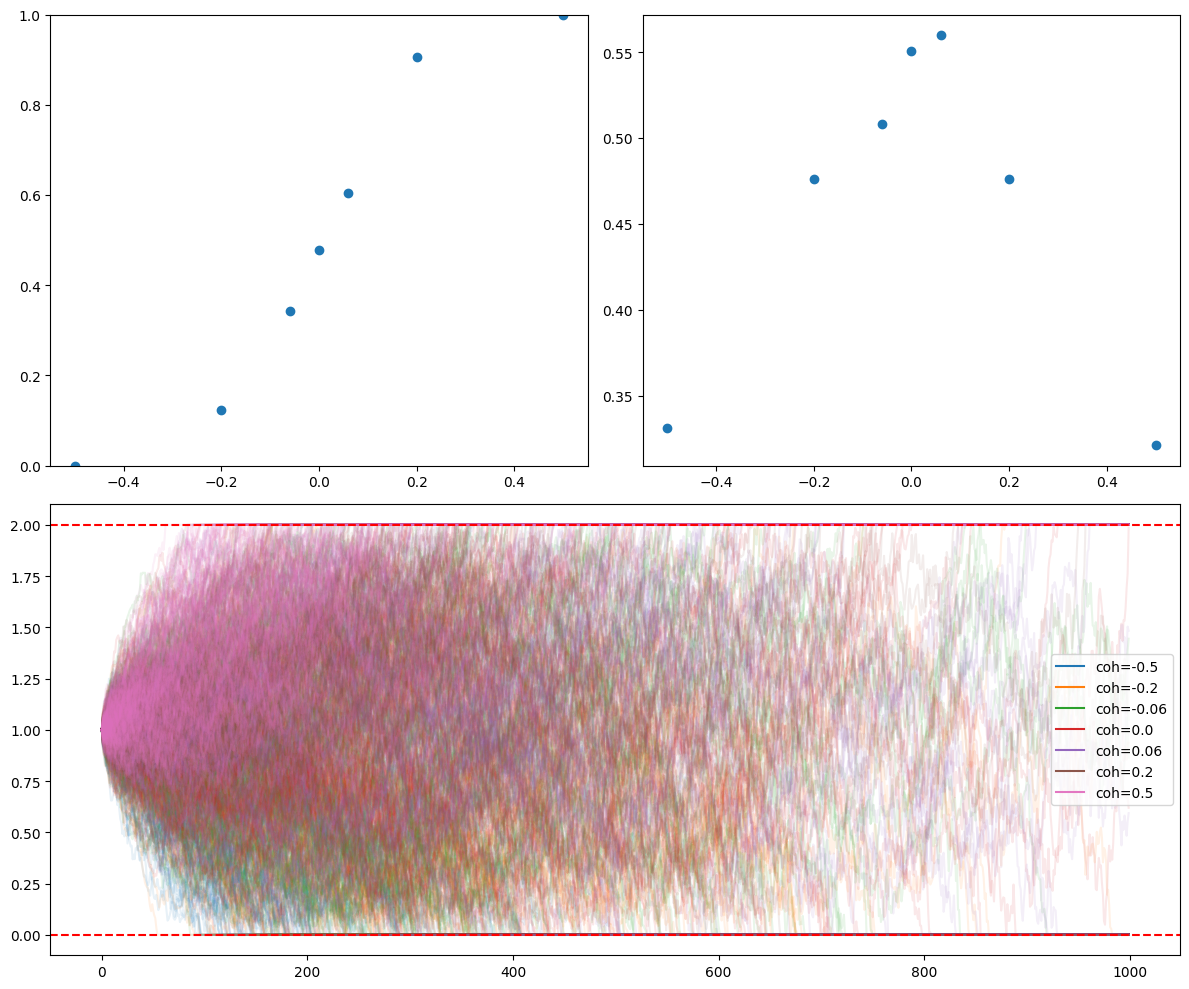

Proportion of invalid trials: 0.011


In [5]:
ddm = DriftDiffusionSimulatorCUDA()

ddm.ndt = 0.1      # non-decision time
ddm.a = 2        # boundary separation
ddm.z = 0.5          # starting point (as a proportion of a)
ddm.drift_gain = 7 # gain on the input to get drift rate
ddm.drift_offset = 0.0
ddm.variance = 1   # variance of the noise in the accumulation process
ddm.dt = 0.001        # time step for simulation
ddm.leak_rate = 0.1     # leakage parameter
ddm.time_constant = 1e-3 # urgency signal time constant



rt, choice,dv = ddm.simulate_trials(stimulus)
data = pd.DataFrame({
    "signed_coherence": stimulus[:,0].flatten(),
    "choice": choice.flatten(),
    "response_time": rt.flatten(),
})
x_data, y_data = get_psychometric_data(data)
_,_,rt_mean,_,_ = get_chronometric_data(data)
fig = plt.figure(figsize=(12,10))
gs = gridspec.GridSpec(2, 2)

# Top-left subplot
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(x_data, y_data, 'o')
ax1.set_ylim(0, 1)

# Top-right subplot
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(x_data, rt_mean, 'o')


# Bottom subplot spanning both columns
ax3 = fig.add_subplot(gs[1, :])
for coh in coherence_levels:
    ax3.plot(dv[stimulus[:,0]==coh].T, color=sns.color_palette("tab10")[coherence_levels.index(coh)], alpha=0.1)
    ax3.plot([],[], color=sns.color_palette("tab10")[coherence_levels.index(coh)], alpha=1, label=f'coh={coh}')
ax3.axhline(ddm.a, color='red', linestyle='--')
ax3.axhline(0, color='red', linestyle='--')
ax3.legend()

plt.tight_layout()
plt.show()

print("Proportion of invalid trials:", np.mean(np.isnan(choice)))

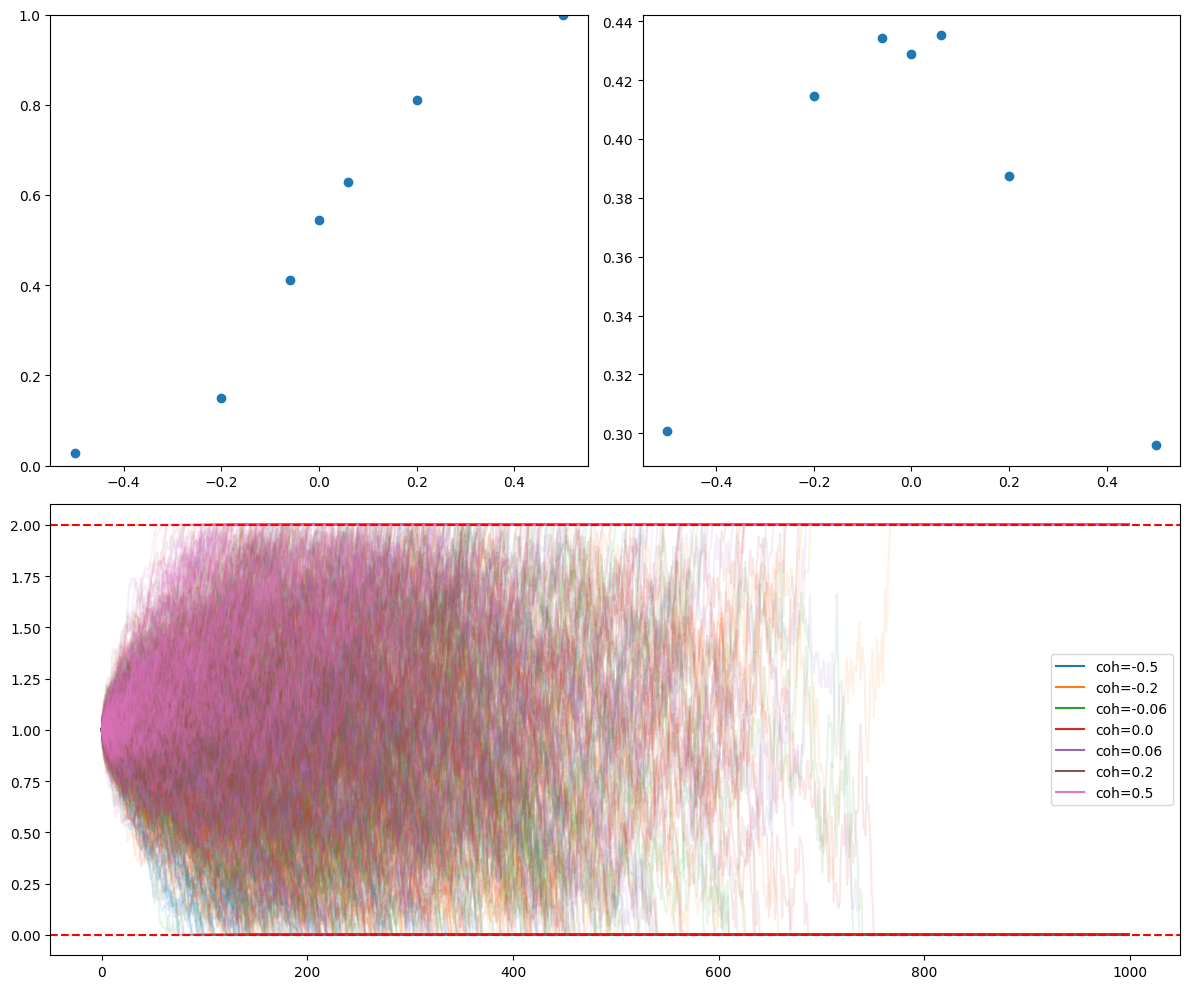

Proportion of invalid trials: 0.0


In [23]:
ddm = DriftDiffusionSimulator()

ddm.ndt = 0.1      # non-decision time
ddm.a = 2        # boundary separation
ddm.z = 0.5          # starting point (as a proportion of a)
ddm.drift_gain = 7 # gain on the input to get drift rate
ddm.drift_offset = 0.0
ddm.variance = 1   # variance of the noise in the accumulation process
ddm.dt = 0.001        # time step for simulation
ddm.leak_rate = 0.1     # leakage parameter
ddm.time_constant = 1e-3 # urgency signal time constant



rt, choice,dv = ddm.simulate_trials(stimulus)
data = pd.DataFrame({
    "signed_coherence": stimulus[:,0].flatten(),
    "choice": choice.flatten(),
    "response_time": rt.flatten(),
})
x_data, y_data = get_psychometric_data(data)
_,_,rt_mean,_,_ = get_chronometric_data(data)
fig = plt.figure(figsize=(12,10))
gs = gridspec.GridSpec(2, 2)

# Top-left subplot
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(x_data, y_data, 'o')
ax1.set_ylim(0, 1)

# Top-right subplot
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(x_data, rt_mean, 'o')


# Bottom subplot spanning both columns
ax3 = fig.add_subplot(gs[1, :])
for coh in coherence_levels:
    ax3.plot(dv[stimulus[:,0]==coh].T, color=sns.color_palette("tab10")[coherence_levels.index(coh)], alpha=0.1)
    ax3.plot([],[], color=sns.color_palette("tab10")[coherence_levels.index(coh)], alpha=1, label=f'coh={coh}')
ax3.axhline(ddm.a, color='red', linestyle='--')
ax3.axhline(0, color='red', linestyle='--')
ax3.legend()

plt.tight_layout()
plt.show()

print("Proportion of invalid trials:", np.mean(np.isnan(choice)))

In [7]:
class LikelihoodCalculator:
    def __init__(self, nbins=9):
        """
        Class to compute Ratcliff-style QMLE likelihoods for diffusion model fits.

        Args:
            nbins (int): Number of quantile bins for RT likelihood estimation (default=9).
        """
        self.nbins = nbins
        self.eps = 1e-24  # small number to avoid log(0)

    def calculate_llh_QMLE(self, rt_model, rt_data):
        """
        Quasi-Maximum Likelihood (Ratcliff quantile likelihood) for RT distributions.

        Args:
            rt_model (array-like): simulated RTs (ms)
            rt_data (array-like): empirical RTs (ms)

        Returns:
            nllh (float): negative log likelihood for RT data given model
        """
        rt_model = np.asarray(rt_model)
        rt_data = np.sort(np.asarray(rt_data))
        n = len(rt_data)
        if self.nbins > n:
            # Fallback: Use fewer bins or skip likelihood
            nbins_used = max(1, n // 2)  # or just 1 bin if very low data
        else:
            nbins_used = self.nbins

        quantiles = np.linspace(0, 1, nbins_used + 1)
        bin_edges = np.quantile(rt_data, quantiles)

        # Expand edges to fully cover model RTs
        bin_edges[0] = min(bin_edges[0], np.min(rt_model))
        bin_edges[-1] = max(bin_edges[-1], np.max(rt_model))

        counts_per_bin = np.histogram(rt_data, bins=bin_edges)[0]
        probs_per_bin = np.histogram(rt_model, bins=bin_edges)[0] / len(rt_model)

        nllh = -np.sum(counts_per_bin * np.log(probs_per_bin + self.eps))
        return nllh

    def calculate_choice_likelihood(self, choice_model, choice_data):
        """
        Negative log likelihood for choice proportions.

        Args:
            choice_model (array-like): simulated choices
            choice_data (array-like): empirical choices

        Returns:
            nllh (float): negative log likelihood for choice data given model
        """
        choice_model = np.asarray(choice_model)
        choice_data = np.asarray(choice_data)

        categories = np.unique(choice_data)
        nllh = 0.0
        for cat in categories:
            n_cat_data = np.sum(choice_data == cat)
            p_cat_model = np.mean(choice_model == cat)
            nllh -= n_cat_data * np.log(p_cat_model + self.eps)
        return nllh

    def calculate_total_llh_per_choice(self, prediction, data):
        """
        Computes Ratcliff-style QMLE negative log likelihood summed over coherence × choice subsets.

        Args:
            prediction (dict): keys 'signed_coherence', 'choice', 'rt' with arrays of model predictions
            data (dict): keys 'signed_coherence', 'choice', 'rt' with arrays of empirical data

        Returns:
            total_nllh (float): total negative log likelihood
        """
        # remove trials with NaN choices or RTs
        mask_data = (~np.isnan(data['choice'])) & (~np.isnan(data['rt']))
        data = {k: v[mask_data] for k, v in data.items()}
        mask_model = (~np.isnan(prediction['choice'])) & (~np.isnan(prediction['rt']))
        prediction = {k: v[mask_model] for k, v in prediction.items()}


        total_nllh = 0.0
        unique_cohs = np.unique(data['signed_coherence'])
        unique_choices = np.unique(data['choice'])

        for coh in unique_cohs:
            mask_data_coh = data['signed_coherence'] == coh
            mask_model_coh = prediction['signed_coherence'] == coh

            if np.sum(mask_data_coh) == 0 or np.sum(mask_model_coh) == 0:
                continue

            choice_data_coh = data['choice'][mask_data_coh]
            choice_model_coh = prediction['choice'][mask_model_coh]

            if len(choice_data_coh) == 0 or len(choice_model_coh) == 0:
                continue

            # Choice likelihood per coherence
            nllh_choice = 0.0
            for choice_val in unique_choices:
                n_choice_data = np.sum(choice_data_coh == choice_val)
                p_choice_model = np.mean(choice_model_coh == choice_val)
                nllh_choice -= n_choice_data * np.log(p_choice_model + self.eps)
            total_nllh += nllh_choice

            # RT likelihood per choice
            for choice_val in unique_choices:
                mask_data = mask_data_coh & (data['choice'] == choice_val)
                mask_model = mask_model_coh & (prediction['choice'] == choice_val)

                rt_data_sub = data['rt'][mask_data]
                rt_model_sub = prediction['rt'][mask_model]

                if len(rt_data_sub) == 0 or len(rt_model_sub) == 0:
                    continue

                nllh_rt = self.calculate_llh_QMLE(rt_model_sub, rt_data_sub)
                total_nllh += nllh_rt

        return total_nllh


In [10]:
class DecisionModel:
    """Main class for decision-making model simulation and fitting."""

    def __init__(
        self,
        model_name: str = 'DDM',
        enable_leak: bool = True,
        enable_time_dependence: bool = True,
        likelihood_function: Optional[Callable] = None,
        likelihood_params: Optional[Dict] = None,
    ):
        """
        Initialize the decision model with parameters.

        Args:
            model_name (str): Model variant name, e.g., 'DDM', 'Race', 'LCA'.
            enable_leak (bool): Whether to include leak in the accumulation process.
            enable_time_varying_drift (bool): Whether to include time-dependent drift (urgency).
            likelihood_function (Callable or None): Custom likelihood function. Defaults to internal QMLE.
            likelihood_params (dict or None): Parameters to configure the likelihood calculation (e.g., nbins).
        """
        self.model_name = model_name
        self.enable_leak = enable_leak
        self.enable_time_dependence = enable_time_dependence

        # Initialize simulator based on model_name — extend this as needed
        if model_name.upper() == 'DDM':
            # self.simulator = DriftDiffusionSimulator(leak=enable_leak, time_dependence=enable_time_dependence)
            self.simulator = DriftDiffusionSimulatorCUDA(leak=enable_leak, time_dependence=enable_time_dependence)
        else:
            raise NotImplementedError(f"Simulator for model '{model_name}' not implemented.")

        # Setup likelihood calculator with default or user-defined function
        if likelihood_params is None:
            likelihood_params = {'nbins': 9}

        if likelihood_function is not None:
            self.likelihood_calculator = likelihood_function
        else:
            self.likelihood_calculator = LikelihoodCalculator(**likelihood_params)


    def fit(self, data, stimulus, optimizer_options=None):
        """
        Fit the model to empirical data using optimization.

        Args:
            data (dict or DataFrame): Empirical data with keys/columns 'signed_coherence', 'choice', 'rt'.
            stimulus (array-like): Stimulus input for each trial.
            optimizer_options (dict or None): Options for the optimizer (e.g., method, bounds).

        Returns:
            result: Optimization result object.
        """
        if optimizer_options is None:
            optimizer_options = {'method': 'L-BFGS-B'}

        # Define all parameters with initial values and bounds
        all_params = {
            'ndt': (0.1, (0.05, 0.3)),
            'a': (2.0, (0.5, 5.0)),
            'z': (0.5, (0.1, 0.9)),
            'drift_gain': (7.0, (1.0, 20.0)),
            'drift_offset': (0.0, (-5.0, 5.0)),
            'variance': (1.0, (0.1, 5.0)),
        }

        if self.enable_leak:
            all_params['leak_rate'] = (0.1, (0.0, 1.0))

        if self.enable_time_dependence:
            all_params['time_constant'] = (1e-2, (0.0, 1.0))

        param_names = list(all_params.keys())
        initial_params = [all_params[name][0] for name in param_names]
        bounds = [all_params[name][1] for name in param_names]

        def objective_function(params, lambda_l1=0.01):
            # Map params to simulator attributes dynamically
            for name, value in zip(param_names, params):
                setattr(self.simulator, name, value)


            # Run simulation
            rt_model, choice_model, _ = self.simulator.simulate_trials(stimulus)

            prediction = {
                'signed_coherence': stimulus[:, 0],
                'choice': choice_model,
                'rt': rt_model,
            }

            # Compute negative log likelihood
            nllh = self.likelihood_calculator.calculate_total_llh_per_choice(prediction, data)
            # L2 penalty
            l1_penalty = lambda_l1 * np.sum(np.abs(params))
            return nllh + l1_penalty


        method = optimizer_options.get('method', 'L-BFGS-B')
        if method in ['L-BFGS-B', 'TNC', 'SLSQP']:
            result = minimize(
                objective_function,
                x0=initial_params,
                bounds=bounds,
                options=optimizer_options,
                method=method,
            )
        elif method in ['Nelder-Mead', 'Powell']:
            result = minimize(
                objective_function,
                x0=initial_params,
                options=optimizer_options,
                method=method,
            )
        else:
            raise ValueError(f"Unsupported optimization method: {method}")

        return result


In [12]:
# import torch

# class DriftDiffusionSimulatorCUDA:
#     def __init__(self, leak=True, time_dependence=True, device=None):
#         self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#         self.ndt = 0.1
#         self.a = 2.0
#         self.z = 0.5
#         self.drift_gain = 7.0
#         self.drift_offset = 0.0
#         self.variance = 1.0
#         self.dt = 0.001
#         self.leak_rate = 0.01 if leak else 0.0
#         self.time_constant = 1e-2 if time_dependence else 0.0

#     def simulate_trials(self, stimulus):
#         # Convert input to a tensor on the right device and float dtype
#         stimulus = torch.tensor(stimulus, device=self.device, dtype=torch.float32)
#         n_trials, n_timepoints = stimulus.shape

#         starting_point = self.z * self.a

#         # Initialize decision variable array and set starting point
#         dv = torch.full((n_trials, n_timepoints), float('nan'), device=self.device, dtype=torch.float32)
#         dv[:, 0] = starting_point

#         # Initialize reaction times and choices as NaNs
#         rt = torch.full((n_trials,), float('nan'), device=self.device, dtype=torch.float32)
#         choice = torch.full((n_trials,), float('nan'), device=self.device, dtype=torch.float32)
#         done = torch.zeros(n_trials, dtype=torch.bool, device=self.device)

#         # Calculate drift rates from stimulus
#         drift_rates = self.drift_gain * stimulus + self.drift_offset

#         for t in range(1, n_timepoints):
#             # Only update trials that have not finished
#             running = ~done

#             if running.sum() == 0:
#                 break

#             prev_dv = dv[running, t - 1]

#             noise = torch.randn(running.sum(), device=self.device, dtype=torch.float32) * torch.sqrt(torch.tensor(self.variance * self.dt, device=self.device))
#             drift = drift_rates[running, t - 1] * self.dt
#             leak = -self.leak_rate * (prev_dv - starting_point) * self.dt

#             dv_new = prev_dv + drift + noise + leak

#             # Urgency signal scaling
#             exp_factor = torch.exp(torch.tensor(t * self.time_constant, device=self.device, dtype=torch.float32))
#             dv_new = exp_factor * dv_new

#             dv[running, t] = dv_new

#             # Detect boundary crossings
#             crossed_up = dv_new >= self.a
#             crossed_down = dv_new <= 0
#             crossed = crossed_up | crossed_down

#             # Indices of trials just finished crossing boundaries
#             just_finished_idx = torch.nonzero(running)[crossed]
#             just_finished_idx = just_finished_idx.flatten()

#             if just_finished_idx.numel() > 0:
#                 rt[just_finished_idx] = t * self.dt + self.ndt
#                 choice_vals = torch.where(crossed_up[crossed], torch.tensor(1., device=self.device), torch.tensor(0., device=self.device))
#                 choice[just_finished_idx] = choice_vals

#                 n_finished = just_finished_idx.shape[0]
#                 a_fill = torch.full((n_finished, n_timepoints - t), self.a, device=self.device, dtype=torch.float32)
#                 zero_fill = torch.zeros((n_finished, n_timepoints - t), device=self.device, dtype=torch.float32)

#                 up_mask = crossed_up[crossed].unsqueeze(1)  # shape (n_finished, 1)

#                 dv[just_finished_idx, t:] = torch.where(up_mask, a_fill, zero_fill)

#                 done[just_finished_idx] = True



#         return rt.cpu().numpy(), choice.cpu().numpy(), dv.cpu().numpy()


In [ ]:
ddm = DriftDiffusionSimulator()

ddm.ndt = 0.1      # non-decision time
ddm.a = 2        # boundary separation
ddm.z = 0.5          # starting point (as a proportion of a)
ddm.drift_gain = 7 # gain on the input to get drift rate
ddm.drift_offset = 0.0
ddm.variance = 1   # variance of the noise in the accumulation process
ddm.dt = 0.001        # time step for simulation
ddm.leak_rate = 0.1     # leakage parameter
ddm.time_constant = 0#1e-2 # urgency signal time constant


# stimulus_length = np.random.randint(300,1000,size=1000)
stimulus = np.full((1000, 1000), np.nan)
coherence_levels = [-0.5, -0.2, -0.06, 0.0, 0.06, 0.2, 0.5]
for i in range(stimulus.shape[0]):
    stimulus[i, :] = np.random.choice(coherence_levels)


rt, choice,dv = ddm.simulate_trials(stimulus)
data = pd.DataFrame({
    "signed_coherence": stimulus[:,0].flatten(),
    "choice": choice.flatten(),
    "rt": rt.flatten(),
})
data = data[~np.isnan(data["choice"])]

data.shape

(792, 3)

In [13]:
model = DecisionModel(enable_leak=True, enable_time_dependence=True)

result = model.fit(data, stimulus, optimizer_options={'method': 'L-BFGS-B', 'disp': True, 'maxiter': 100})

/tmp/ipykernel_1758918/2331164452.py:102: OptimizeWarning: Unknown solver options: method
  result = minimize(


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.11703D+04    |proj g|=  1.01863D-02

At iterate    1    f=  2.54677D+03    |proj g|=  5.98981D+00
  ys=-1.985E+09  -gs= 8.282E-04 BFGS update SKIPPED

At iterate    2    f=  2.22164D+03    |proj g|=  5.98981D+00

At iterate    3    f=  2.34435D+03    |proj g|=  5.98981D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      3     29     12     1     1   5.990D+00   2.344D+03
  F =   2344.3464890821515     

CONVERGENCE: REL_

In [14]:
print(result.x, result.fun)


[ 8.98136567e-02  1.98981386e+00  4.89813633e-01  6.98981326e+00
 -1.01860086e-02  9.89813600e-01  8.98136533e-02  6.61636759e-08] 2344.3464890821515
